## Task 2 - Semantic Search on NiniSite

In [ ]:
%%capture
!pip uninstall -y numpy scipy scikit-learn
!pip install -U "numpy==1.26.4" "scipy==1.11.*" "scikit-learn==1.3.2" pandas==2.2.2 hazm emoji arabic_reshaper python-bidi wordcloud nltk sentence-transformers FlagEmbedding lancedb pyarrow

In [1]:
import json
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bidi.algorithm import get_display
import arabic_reshaper
from collections import Counter
from hazm import stopwords_list
from nltk.util import ngrams
from wordcloud import WordCloud
from hazm import *
import emoji
from FlagEmbedding import BGEM3FlagModel
from sentence_transformers import SentenceTransformer
import torch
from lancedb.embeddings import TextEmbeddingFunction, register, EmbeddingFunctionRegistry
from typing import ClassVar, List, Union
from pydantic import PrivateAttr
import lancedb
from lancedb.pydantic import LanceModel, Vector
import os, math
from lancedb.embeddings import get_registry
from sentence_transformers import CrossEncoder

In [ ]:
with open('./PerCQA_JSON_Format.json', 'r', encoding='utf-8-sig') as f:
    data = json.load(f)

df = pd.json_normalize(
    data,
    record_path='Comments',
    meta=['QID', 'QDATE', 'QUSERID', 'QTYPE', 'QGOLD_YN', 'QUsername', 'QBody', 'QSubject'],
    errors='ignore'
)

In [ ]:
df.head()

,CID,CUSERID,CGOLD,CGOLD_YN,CSubject,CBody,CBodyClean,CUsername,CDate,LabelDate,ReplayCommentId,QID,QDATE,QUSERID,QTYPE,QGOLD_YN,QUsername,QBody,QSubject
0,50758322,4918,Good,,,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,mahboub,None,2020-04-28T23:57:28.9458377,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
1,50758362,4939,Good,,,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,انقدر تحویلش نگیر تا خودش بیاد سمتت ، این جوری...,eshghiii,None,2020-04-29T00:32:46.1344058,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
2,50758382,9102,Good,,,تولد براش بگير. قهر جداس,تولد براش بگیر. قهر جداس,44,None,2020-04-29T00:32:48.054768,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
3,50758410,9103,Good,,,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,تولدشون رو تبریک بگین. جوری که احساس نکنن داری...,golsa82,None,2020-04-29T00:43:34.305984,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
4,50758416,8643,Good,,,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,بهاران_عشق,None,2020-04-29T00:43:41.4450752,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم


In [ ]:
df.drop(columns=['CBody'], inplace=True)

In [ ]:
df.head()

,CID,CUSERID,CGOLD,CGOLD_YN,CSubject,CBodyClean,CUsername,CDate,LabelDate,ReplayCommentId,QID,QDATE,QUSERID,QTYPE,QGOLD_YN,QUsername,QBody,QSubject
0,50758322,4918,Good,,,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,mahboub,None,2020-04-28T23:57:28.9458377,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
1,50758362,4939,Good,,,انقدر تحویلش نگیر تا خودش بیاد سمتت ، این جوری...,eshghiii,None,2020-04-29T00:32:46.1344058,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
2,50758382,9102,Good,,,تولد براش بگیر. قهر جداس,44,None,2020-04-29T00:32:48.054768,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
3,50758410,9103,Good,,,تولدشون رو تبریک بگین. جوری که احساس نکنن داری...,golsa82,None,2020-04-29T00:43:34.305984,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
4,50758416,8643,Good,,,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,بهاران_عشق,None,2020-04-29T00:43:41.4450752,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم


In [ ]:
df.rename(columns={
    'CBodyClean': 'CBody',
}, inplace=True)
df['CBodyClean'] = df['CBody'].copy()


In [ ]:
df.head()

,CID,CUSERID,CGOLD,CGOLD_YN,CSubject,CBody,CUsername,CDate,LabelDate,ReplayCommentId,QID,QDATE,QUSERID,QTYPE,QGOLD_YN,QUsername,QBody,QSubject,CBodyClean
0,50758322,4918,Good,,,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,mahboub,None,2020-04-28T23:57:28.9458377,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...
1,50758362,4939,Good,,,انقدر تحویلش نگیر تا خودش بیاد سمتت ، این جوری...,eshghiii,None,2020-04-29T00:32:46.1344058,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم,انقدر تحویلش نگیر تا خودش بیاد سمتت ، این جوری...
2,50758382,9102,Good,,,تولد براش بگیر. قهر جداس,44,None,2020-04-29T00:32:48.054768,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم,تولد براش بگیر. قهر جداس
3,50758410,9103,Good,,,تولدشون رو تبریک بگین. جوری که احساس نکنن داری...,golsa82,None,2020-04-29T00:43:34.305984,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم,تولدشون رو تبریک بگین. جوری که احساس نکنن داری...
4,50758416,8643,Good,,,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,بهاران_عشق,None,2020-04-29T00:43:41.4450752,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...


In [ ]:
df = df.dropna(subset=['CBody']).reset_index(drop=True)

In [ ]:
def remove_punctuations(text):
    punctuations_to_remove = string.punctuation + '،' + '؟' + '«' + '»' + '…'
    punc_pattern = f"[{re.escape(punctuations_to_remove)}]"
    text = re.sub(punc_pattern, '', text)
    return text
df['CBody'] = df['CBody'].apply(remove_punctuations)

In [ ]:
df['CBody']

,CBody
0,قهر جدا تولد جدا ضمنا خواهرانه میگم این قهر و ...
1,انقدر تحویلش نگیر تا خودش بیاد سمتت این جوری ...
2,تولد براش بگیر قهر جداس
3,تولدشون رو تبریک بگین جوری که احساس نکنن دارین...
4,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...
...,...
21980,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...
21981,اون مسئله قبلی حل شد خواهرم با خودش مطرح کرد و...
21982,جعبه شکلات بنظرم شکلات خیلی رسمی نمیاد چیزی که...
21983,بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون


### Preprocessing

#### Normalization

In [ ]:
normalizer = Normalizer(
    correct_spacing=True,
    remove_diacritics=True,
    remove_specials_chars=True,
    decrease_repeated_chars=True,
    persian_style=True,
    persian_numbers=True,
    unicodes_replacement=True,
    seperate_mi=True
    )
original_texts = df[df['CBody'].str.contains('ك|ي', na=False)]
print("--- Before Normalization ---")
print(original_texts[['CBody']].head())

df['CBody'] = df['CBody'].apply(normalizer.normalize)

print("\n--- After Normalization ---")
print(df.loc[original_texts.index, ['CBody']].head())

--- Before Normalization ---
                                                   CBody
4232   سلام خانم تو خونهخونه دار هاي نمونه😀بفرماييد ا...
5685   سلام خانم تو خونهخونه دار هاي نمونه😀بفرماييد ا...
13173  انتخاب عينك و عدسي بين هزار مدل مختلف با راهنم...

--- After Normalization ---
                                                   CBody
4232   سلام خانم تو خونهخونه دار‌های نمونه😀بفرمایید ا...
5685   سلام خانم تو خونهخونه دار‌های نمونه😀بفرمایید ا...
13173  انتخاب عینک و عدسی بین هزار مدل مختلف با راهنم...


#### Remove diacritics and unwanted characters

The `Normalizer` function from `Hazm` has a `remove_diacritics` parameter that can be set to `True` to remove diacritics from the text that is already done in the previous part as it is True by default.

Now it is only needed to remove emojis with below code:

In [ ]:
def convert_emoji_to_text(text):
    return emoji.replace_emoji(text, replace=' ')
df['CBody'] = df['CBody'].apply(convert_emoji_to_text)

In [ ]:
print("\n--- After Removing emojis---")
print(df.loc[original_texts.index, ['CBody']].head())


--- After Removing emojis---
                                                   CBody
4232   سلام خانم تو خونهخونه دار‌های نمونه بفرمایید ا...
5685   سلام خانم تو خونهخونه دار‌های نمونه بفرمایید ا...
13173  انتخاب عینک و عدسی بین هزار مدل مختلف با راهنم...


#### Tokenization

In [ ]:
df['CBody_tokenized'] = df['CBody'].apply(word_tokenize)

In [ ]:
df['CBody_tokenized'].iloc[0]

['قهر',
 'جدا',
 'تولد',
 'جدا',
 'ضمنا',
 'خواهرانه',
 'میگم',
 'این',
 'قهر',
 'و',
 'همین',
 'ابتدای',
 'زندگیت',
 'محوش',
 'کن']

#### Remove stopwords

In [ ]:
stopwords = list(stopwords_list())
stopwords

['آخرین',
 'آقای',
 'آمد',
 'آمده',
 'آمده_است',
 'آن',
 'آنان',
 'آنجا',
 'آنها',
 'آنچه',
 'آنکه',
 'آورد',
 'آوری',
 'آیا',
 'ابتدا',
 'اثر',
 'اجرا',
 'اخیر',
 'از',
 'است',
 'اش',
 'اغلب',
 'افراد',
 'افرادی',
 'افزود',
 'البته',
 'اما',
 'امر',
 'امکان',
 'اند',
 'او',
 'اول',
 'اولین',
 'اکنون',
 'اگر',
 'ایشان',
 'این',
 'اینجا',
 'اینکه',
 'با',
 'بار',
 'باره',
 'باز',
 'باشد',
 'باشند',
 'باعث',
 'بالا',
 'باید',
 'بخش',
 'بخشی',
 'بدون',
 'بر',
 'برابر',
 'براساس',
 'برای',
 'برخی',
 'برداری',
 'بروز',
 'بزرگ',
 'بسیار',
 'بسیاری',
 'بعد',
 'بعضی',
 'بلکه',
 'بنابراین',
 'بندی',
 'به',
 'بهتر',
 'بهترین',
 'بود',
 'بودن',
 'بودند',
 'بوده',
 'بوده_است',
 'بی',
 'بیان',
 'بیرون',
 'بیش',
 'بیشتر',
 'بیشتری',
 'بین',
 'تا',
 'تاکنون',
 'تبدیل',
 'تحت',
 'ترتیب',
 'تعداد',
 'تعیین',
 'تغییر',
 'تمام',
 'تمامی',
 'تنها',
 'تهیه',
 'تو',
 'جا',
 'جاری',
 'جای',
 'جایی',
 'جدی',
 'جدید',
 'جریان',
 'جز',
 'جمع',
 'جمعی',
 'حال',
 'حالا',
 'حالی',
 'حتی',
 'حد',
 'حداقل',
 'حدود',

In [ ]:
def remove_stopwords(text):
    return [word for word in text if word not in stopwords]
df['CBody_tokenized'] = df['CBody_tokenized'].apply(remove_stopwords)

In [ ]:
df['CBody_tokenized'].iloc[0]

['قهر',
 'جدا',
 'تولد',
 'جدا',
 'ضمنا',
 'خواهرانه',
 'میگم',
 'قهر',
 'ابتدای',
 'زندگیت',
 'محوش',
 'کن']

As we can compare to before, the stopwords are omitted.

#### Stemming and Lemmatization

In [ ]:
from hazm import Lemmatizer
lemmatizer = Lemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(word,'') for word in text]
df['CBody_tokenized'] = df['CBody_tokenized'].apply(lemmatize_text)

#### Normalize informal stretching and repetition

The `decrease_repeated_chars` in `Normalizer` has done this before.

#### Replace informal or slang expressions (Bonus Part)

In [ ]:
slangs = {
    "مرسی": "ممنون",
    "آره": "بله",
    "جون": "جان",
    "داداش": "برادر",
    "آجی": "خواهر",
    "خ": "خب",
    "باحال": "جالب",
    "خیلی": "بسیار",
    "چطوری": "چطور هستی",
    "چی": "چه چیزی",
    "دمت گرم": "ممنونم",
    "نوکرتم": "ارادتمندم",
    "قربونت": "قربان شما",
    "بیخیال": "اهمیتی نده",
    "بزن بریم": "بیا برویم",
    "حله": "باشه",
    "اوکی": "باشه",
    "اوک": "باشه",
    "خخ": " ",
    "ههه": " ",
    "هه": " ",
    "عه": " ",
    "عهه": " ",
    "پ ن پ": "پس نه پس",
    "وجدانن": "وجدانا",
    "می شه": "می شود",
    "نمیشه": "نمی شود",
    "میرم": "می روم",
    "میگه": "می گوید",
    "میخوام": "می خواهم",
    "چی کار": "چه کار",
    "کجایی": "کجا هستی",
    "چرا": "برای چه",
}
def replace_slang(token_list):
  return [slangs.get(word, word) for word in token_list]

df['CBody_formalized'] = df['CBody_tokenized'].apply(replace_slang)

example_df = df[df['CBody_tokenized'].astype(str).str.contains("مرسی|خونه")]

print("--- Before Replacing Slang ---")
print(example_df[['CBody_tokenized']].head())

print("\n--- After Replacing Slang ---")
print(example_df[['CBody_formalized']].head())

--- Before Replacing Slang ---
                                       CBody_tokenized
5            [مرسی, عزیزمطاقت, میارم, دور, سرد, میکنه]
44   [اگه, قهر, کشید#کش, چی, الانم, رفته, خونه, مام...
124  [الان, نامزد, رفت#رو, الان, دیگه, عادت, هفته, ...
182  [وای, چیزای, سایت, گفت#گو, مرسی, عزیز, میتونم,...
233  [مرسی, گللم, چندتا, کتاب, براش, خرید#خر, ۳, سا...

--- After Replacing Slang ---
                                      CBody_formalized
5           [ممنون, عزیزمطاقت, میارم, دور, سرد, میکنه]
44   [اگه, قهر, کشید#کش, چه چیزی, الانم, رفته, خونه...
124  [الان, نامزد, رفت#رو, الان, دیگه, عادت, هفته, ...
182  [وای, چیزای, سایت, گفت#گو, ممنون, عزیز, میتونم...
233  [ممنون, گللم, چندتا, کتاب, براش, خرید#خر, ۳, س...


In [ ]:
df['CBody_formalized'][0]

['قهر',
 'جدا',
 'تولد',
 'جدا',
 'ضمنا',
 'خواهرانه',
 'میگ',
 'قهر',
 'ابتدا',
 'زندگیت',
 'محو',
 'کن']

#### Displaying Persian Text Correctly

The words are correctly written and they are RTL.

### EDA

#### Understand the structure of questions and answers

In [ ]:
print("Question1:\n")
print(df["QBody"].iloc[0])
print("\nAnswer:\n")
print(df["CBody"].iloc[0])

Question1:

دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چه کنم؟موضوع دعوامون چیزی بوده که من مقصرش نیستم...خودشم میدونه ربطی به من نداره

Answer:

قهر جدا تولد جدا ضمنا خواهرانه میگم این قهر و همین ابتدای زندگیت محوش کن


In [ ]:
print("Question2:\n")
print(df["QBody"].iloc[1])
print("\nAnswer:\n")
print(df["CBody"].iloc[1])

Question2:

دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چه کنم؟موضوع دعوامون چیزی بوده که من مقصرش نیستم...خودشم میدونه ربطی به من نداره

Answer:

انقدر تحویلش نگیر تا خودش بیاد سمتت این جوری ادب می‌شه که دیگه قهر نکنه البته اگر طاقت میاری که بهش زنگ نزنی اینکاری که گفتم رو انجام بدی بهتر عزیزم


In [ ]:
def correct_persian_display(text):
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)

df['QBody_char_len'] = df['QBody'].str.len()
df['CBody_char_len'] = df['CBody'].str.len()

df['QBody_tokenized'] = df['QBody'].apply(word_tokenize)
df['QBody_word_len'] = df['QBody_tokenized'].apply(len)
df['CBody_word_len'] = df['CBody_tokenized'].apply(len)


ans = df[[
    'QBody_char_len', 'CBody_char_len',
    'QBody_word_len', 'CBody_word_len'
]].agg(['mean', 'median'])
print(ans)

        QBody_char_len  CBody_char_len  QBody_word_len  CBody_word_len
mean         217.29461       88.080646        48.17239       12.553787
median       156.00000       61.000000        34.00000        9.000000


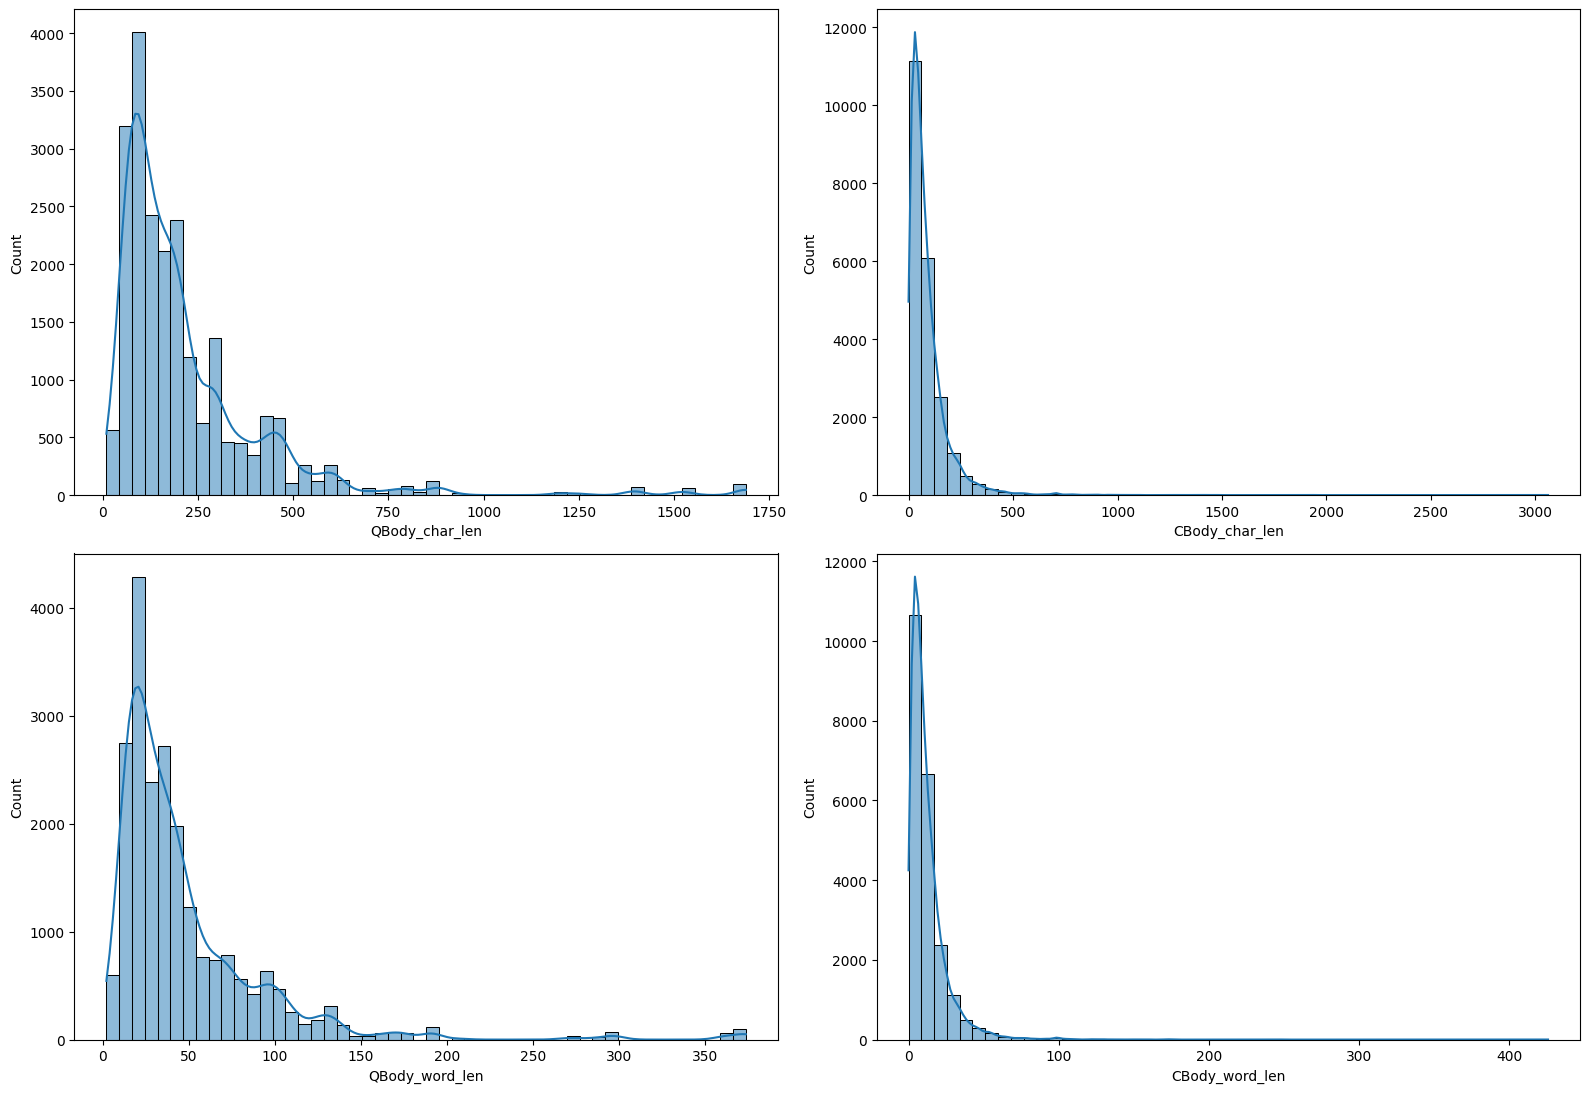

/tmp/ipython-input-2762693774.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Questions", "Answers"])
/tmp/ipython-input-2762693774.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Questions", "Answers"])


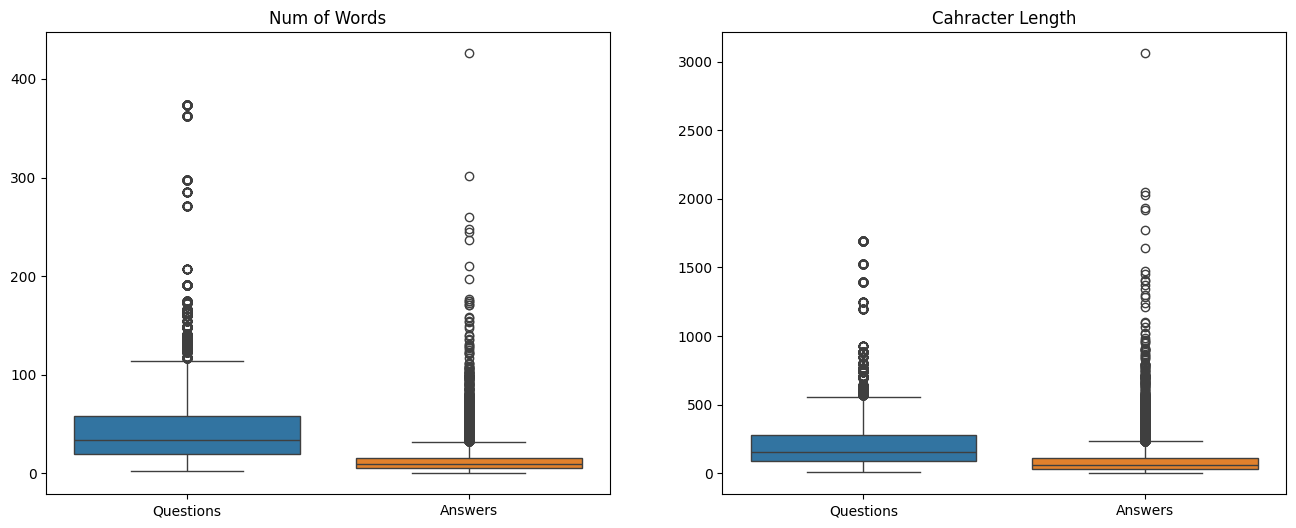

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Sans'
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.histplot(df['QBody_char_len'], ax=axes[0, 0], kde=True, bins=50)

sns.histplot(df['CBody_char_len'], ax=axes[0, 1], kde=True, bins=50)

sns.histplot(df['QBody_word_len'], ax=axes[1, 0], kde=True, bins=50)

sns.histplot(df['CBody_word_len'], ax=axes[1, 1], kde=True, bins=50)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=df[['QBody_word_len', 'CBody_word_len']], ax=axes[0])
axes[0].set_title("Num of Words")
axes[0].set_xticklabels(["Questions", "Answers"])


sns.boxplot(data=df[['QBody_char_len', 'CBody_char_len']], ax=axes[1])
axes[1].set_title("Cahracter Length")
axes[1].set_xticklabels(["Questions", "Answers"])

plt.show()

#### Identify the most engaging questions

In [ ]:
temp_dict = {}
rows = df.shape[0]
cur_id = df["QID"].iloc[0]
num = 0
for i in range(rows):
    if df["QID"].iloc[i] != cur_id:
        temp_dict[cur_id] = [num, df["QSubject"].iloc[i-1]]
        cur_id = df["QID"].iloc[i]
        num = 0
    else:
        num += 1

In [ ]:
sorted_dict = dict(sorted(temp_dict.items(), key=lambda item: item[1][0],reverse=True))
sorted_dict

{'1556257': [314, 'با ١٥ ميليون چه چزایی برای جهازتون ميخرين؟ '],
 '1577970': [312, 'خواندن عقد توسط سید محمد خاتمی'],
 '1559359': [214, 'کیا طلاق گرفتن...'],
 '1555428': [214, 'گواهی سلامت برم بگیرم ؟ '],
 '1578477': [165, 'اونایی که شوهراشون خیلی نازشونو میکشه بیان'],
 '1569562': [143, 'میخوام یه چی به شوهرم بگم ولی نمیتونم.'],
 '1591164': [142, 'شوهرتون ماشین بخره به نامتون نزنه ناراحت میشید؟'],
 '1585904': [136, 'خواستم به خواستگارم بگم بیماری دارم اما....'],
 '1567278': [136, 'خواستگار'],
 '1575297': [135, 'بیاین بگین چکارکنم باشوهرم'],
 '1554952': [128, 'با نامزدم دعوام شده.صدام رو ضبط کرده'],
 '1555344': [124, 'خواستگاریم نزدیکه استرس دارم. '],
 '1564216': [118, 'بکارت'],
 '1574016': [117, 'نامزدی'],
 '1567277': [111, 'جاریه هنوز نیومده، داره همه رو دعوا میندازه چیکار کنم؟'],
 '1569749': [106, 'خواستگار خواهرم'],
 '1580050': [104, 'نامزدی به این سرعت برای من عجیبه یا اینکه واقعا همینطوره؟'],
 '1582600': [103, 'مشاور میگه جدا شو'],
 '1716882': [97, 'دلیل جداییم منطقیه '],
 '15649

#### Analyze user activity patterns

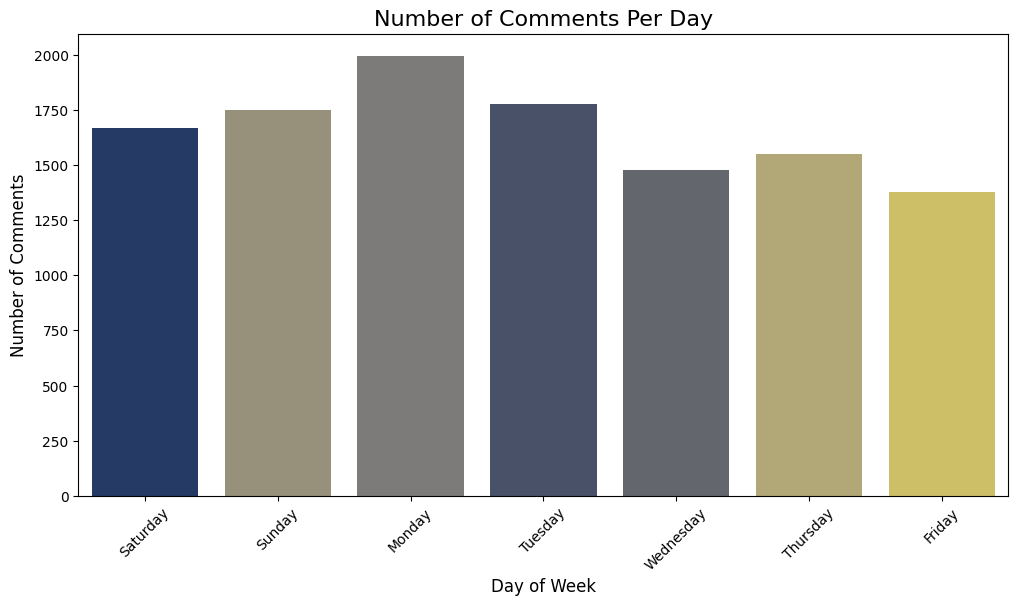

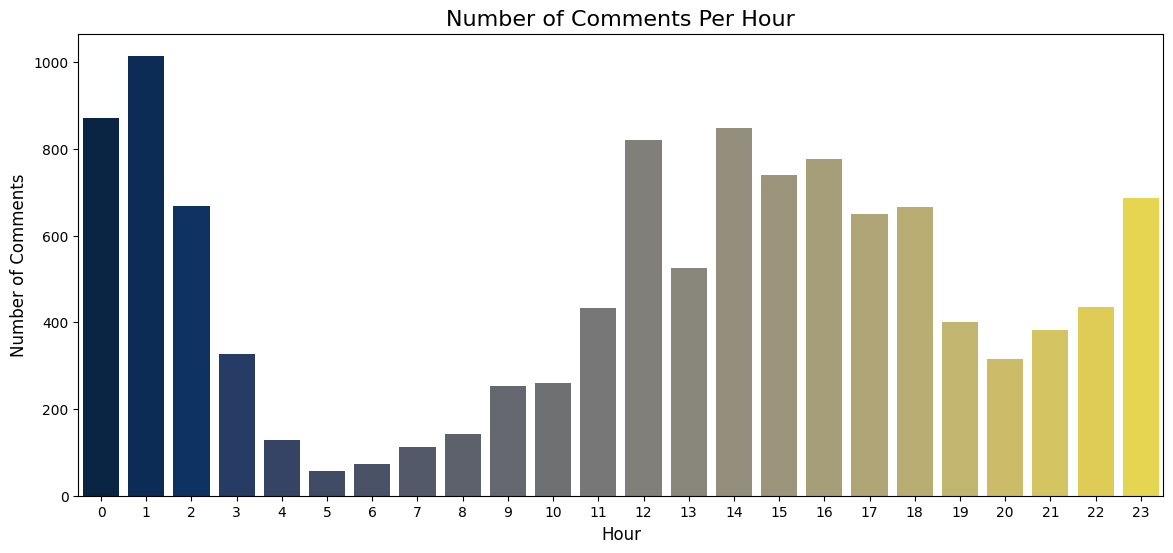

In [ ]:
df['CDate'] = pd.to_datetime(df['CDate'], errors='coerce')
df_activity = df.dropna(subset=['CDate']).copy()
df_activity.loc[:, 'DayOfWeek'] = df_activity['CDate'].dt.day_name()
df_activity.loc[:, 'Hour'] = df_activity['CDate'].dt.hour
day_order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

plt.figure(figsize=(12, 6))
sns.countplot(x='DayOfWeek', data=df_activity, order=day_order, palette='cividis', hue='DayOfWeek', legend=False)
plt.title("Number of Comments Per Day", fontsize=16)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.xticks(ticks=range(7), labels=day_order, rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(x='Hour', data=df_activity, palette='cividis', hue='Hour', legend=False)
plt.title("Number of Comments Per Hour", fontsize=16)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.show()

#### Detect top answer contributors

In [ ]:
answer_counts = df['CUsername'].value_counts().reset_index()
answer_counts.columns = ['CUsername', 'AnswerCount']
answer_counts

,CUsername,AnswerCount
0,باران_بهاری95,142
1,بلوبری۳۲۳۷,96
2,a_rezoo,93
3,saghiiii,89
4,عسلیk516,86
...,...,...
6278,مامان_اسرا,1
6279,abremaman,1
6280,mzf,1
6281,لیااناا,1


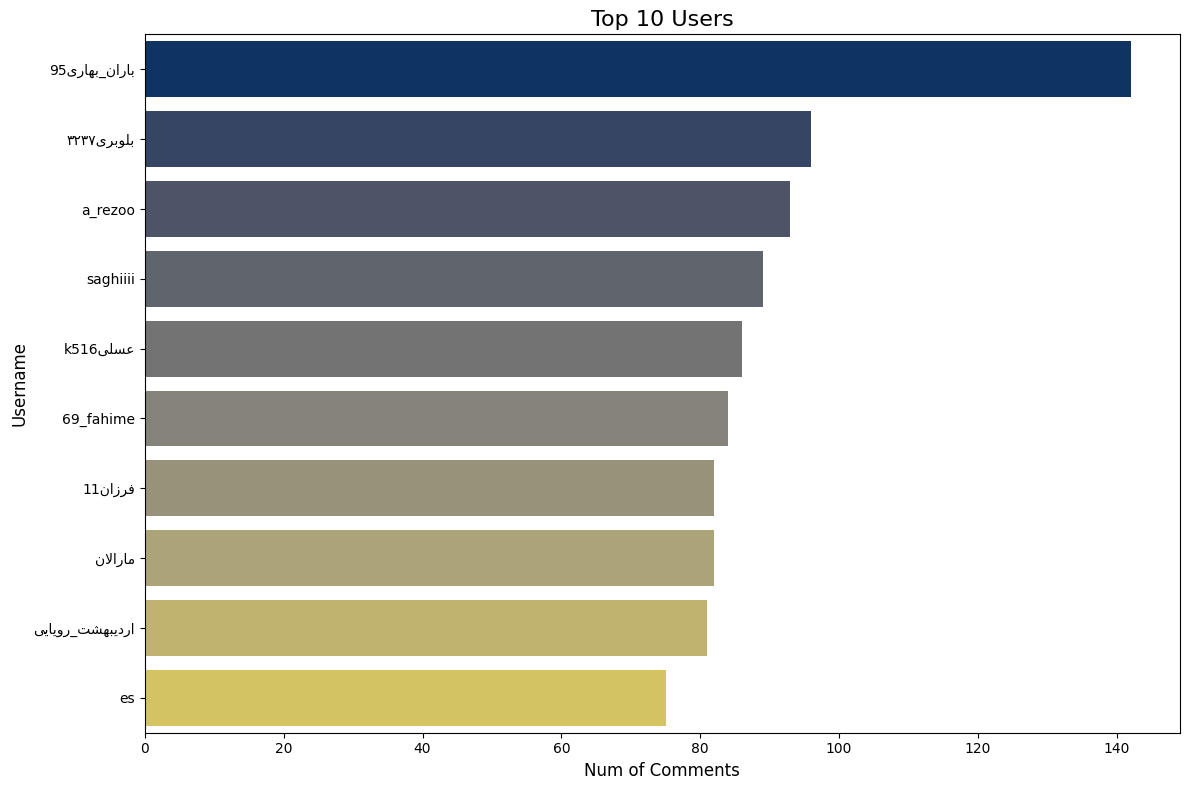

In [ ]:
top_contributors = answer_counts.sort_values(by='AnswerCount', ascending=False)
top_n = 10
plt.figure(figsize=(12, 8))
chart_labels = top_contributors['CUsername'].head(top_n).apply(correct_persian_display)
chart_counts = top_contributors['AnswerCount'].head(top_n)

sns.barplot(x=chart_counts, y=chart_labels, palette='cividis', hue=chart_labels, legend=False)
plt.title("Top 10 Users", fontsize=16)
plt.xlabel("Num of Comments", fontsize=12)
plt.ylabel("Username", fontsize=12)
plt.tight_layout()
plt.show()

#### Linguistic and word-level analysis

In [ ]:
persian_stopwords = set(stopwords_list())
all_question_tokens = [token for sublist in df['QBody_tokenized'] for token in sublist]
all_answer_tokens = [token for sublist in df['CBody_formalized'] for token in sublist]
question_tokens_no_stops = [token for token in all_question_tokens if token not in persian_stopwords]
answer_tokens_no_stops = [token for token in all_answer_tokens if token not in persian_stopwords]

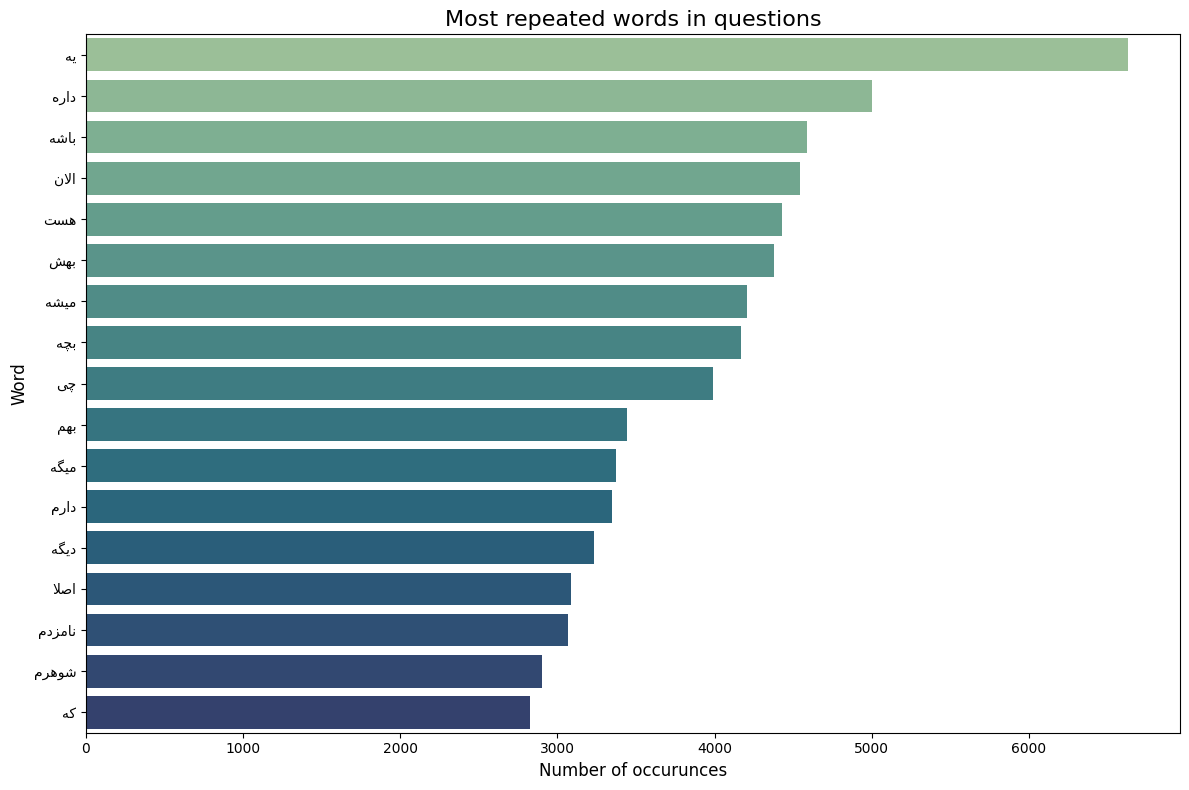

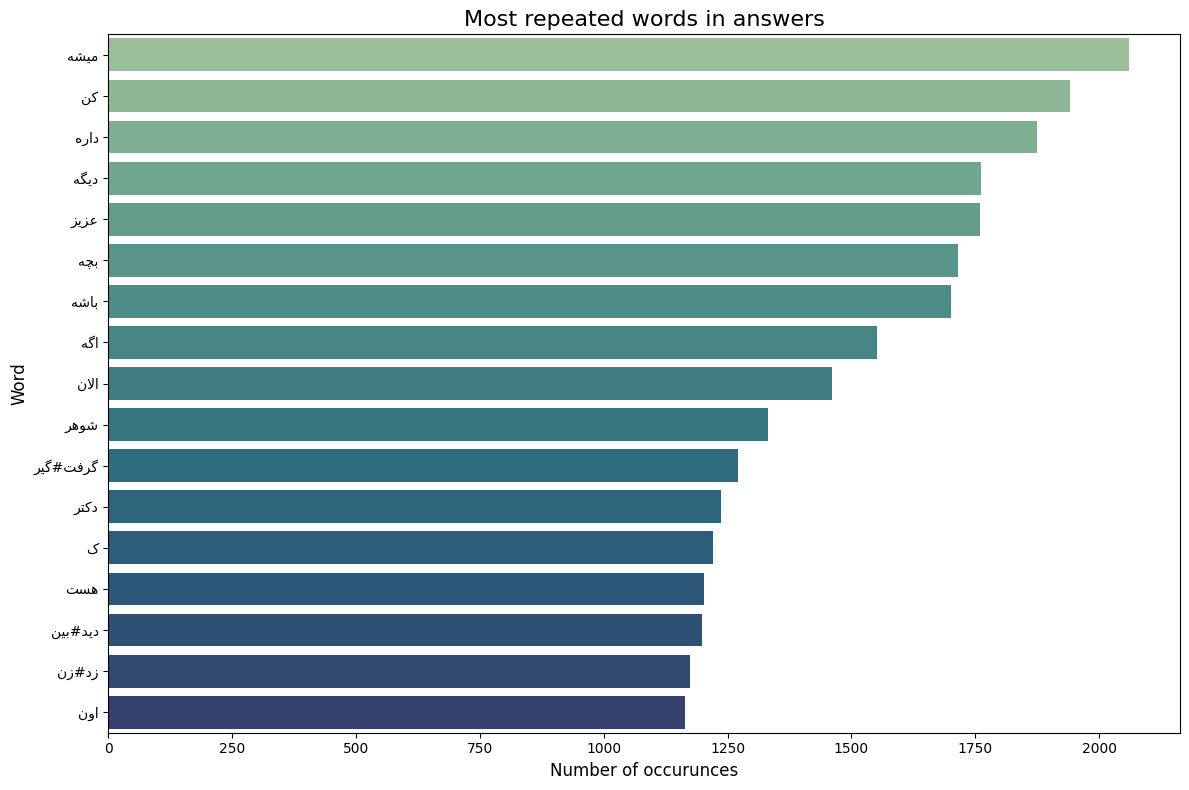

In [ ]:
def correct_persian_display(text):
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)
def plot_word_frequency(tokens, title, top_k=20):
    word_counts = Counter(tokens)
    top_words = word_counts.most_common(top_k)
    words = [word for word, count in top_words[3:]]
    counts = [count for word, count in top_words[3:]]
    persian_labels = [correct_persian_display(word) for word in words]
    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts, y=persian_labels, palette='crest', hue=persian_labels, legend=False)
    plt.title(title, fontsize=16)
    plt.xlabel("Number of occurunces", fontsize=12)
    plt.ylabel("Word", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_word_frequency(question_tokens_no_stops, "Most repeated words in questions")
plot_word_frequency(answer_tokens_no_stops, "Most repeated words in answers")

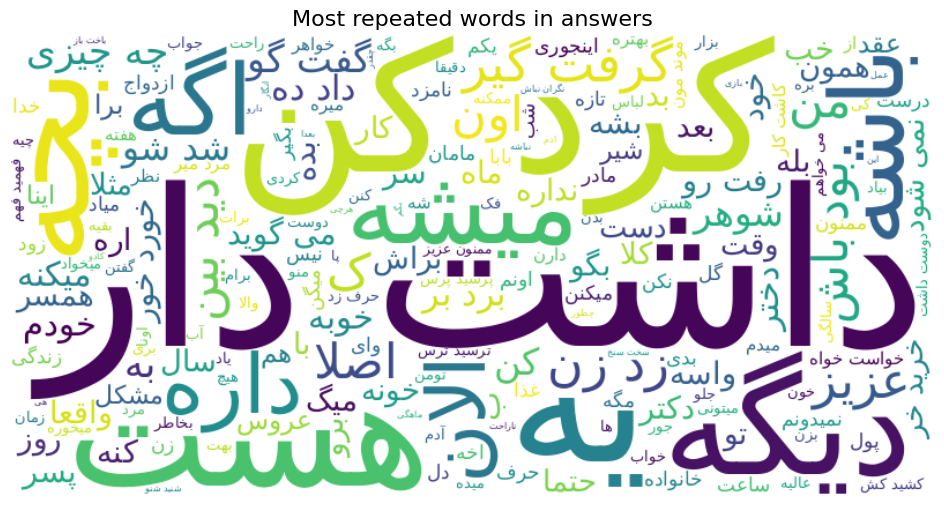

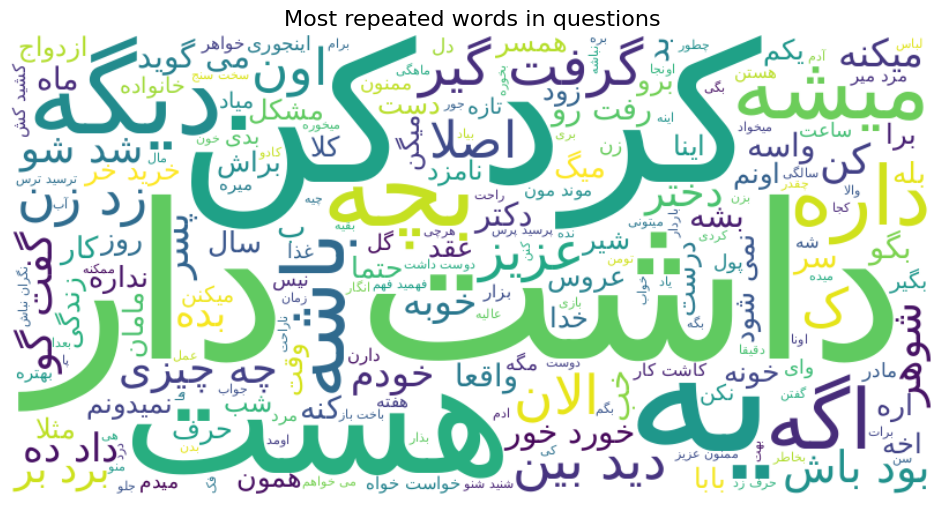

In [ ]:
def generate_wordcloud(tokens, title):
    text = " ".join(tokens)
    reshaped_text = arabic_reshaper.reshape(text)
    font_path = './DejaVuSans.ttf'

    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white'
    ).generate(reshaped_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

generate_wordcloud(all_answer_tokens, "Most repeated words in answers")
generate_wordcloud(answer_tokens_no_stops, "Most repeated words in questions")

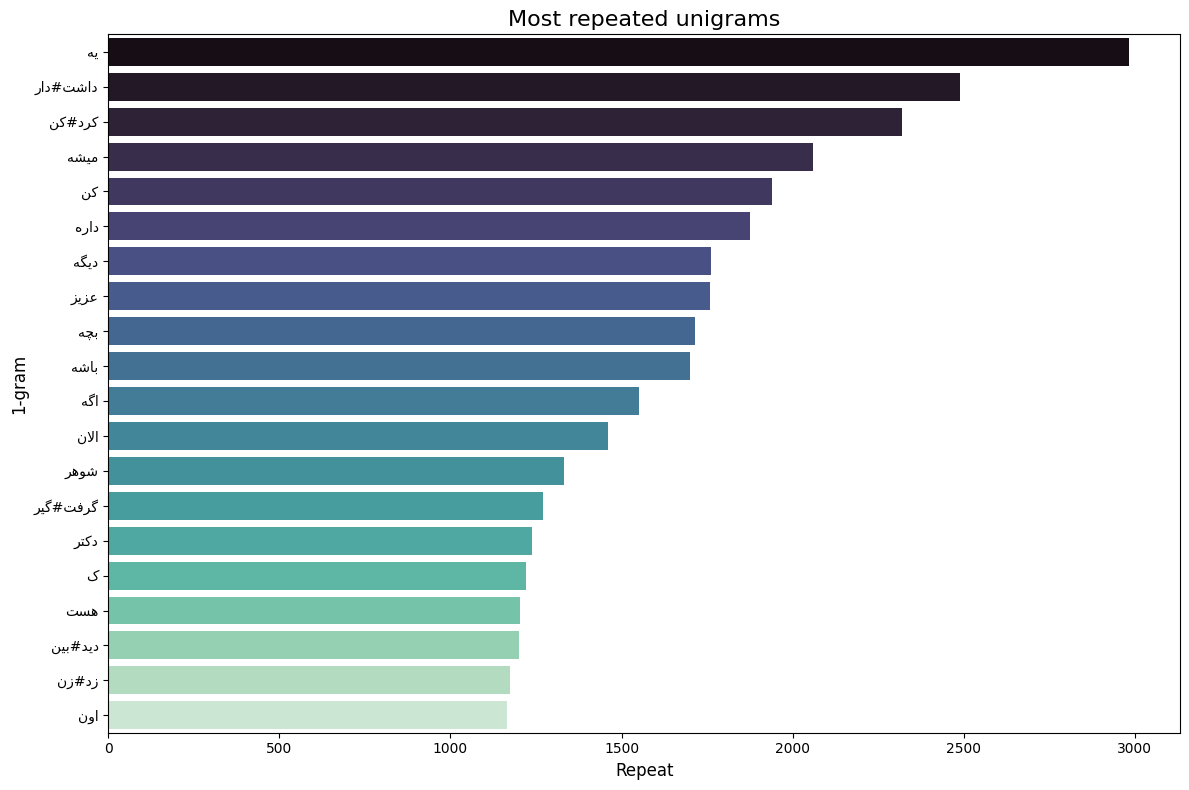

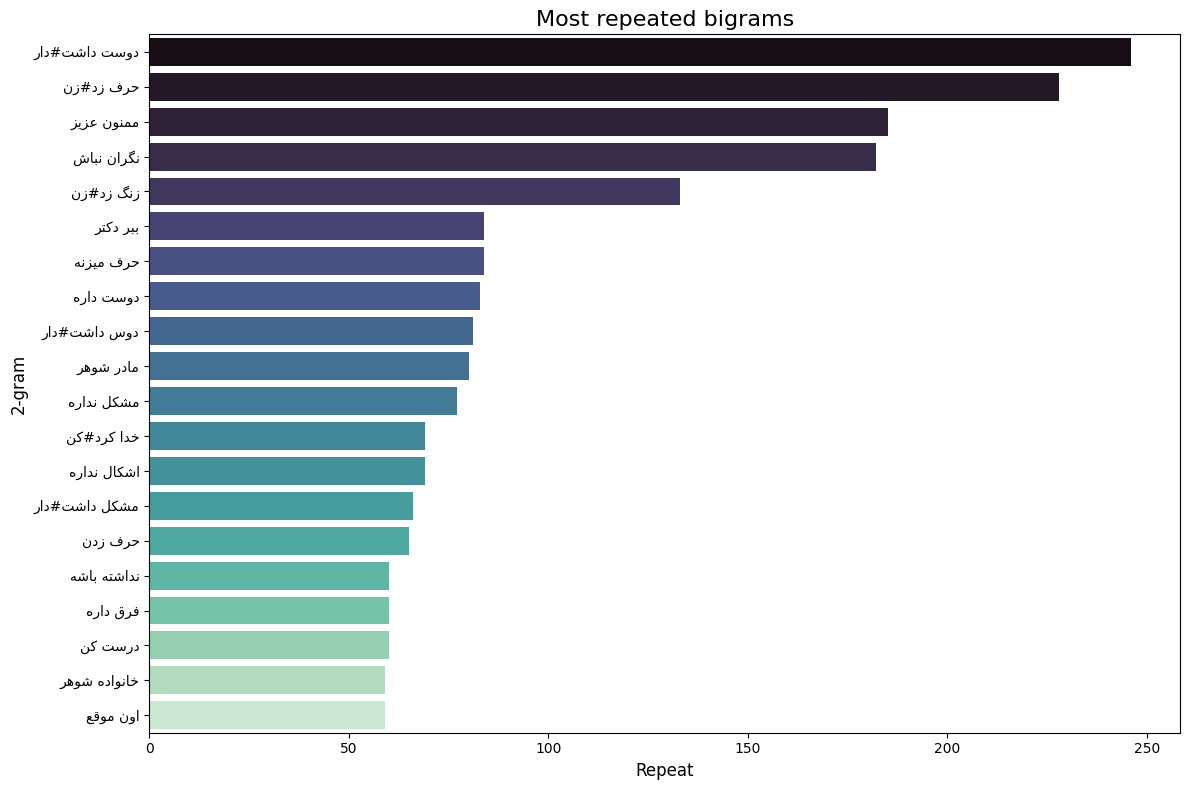

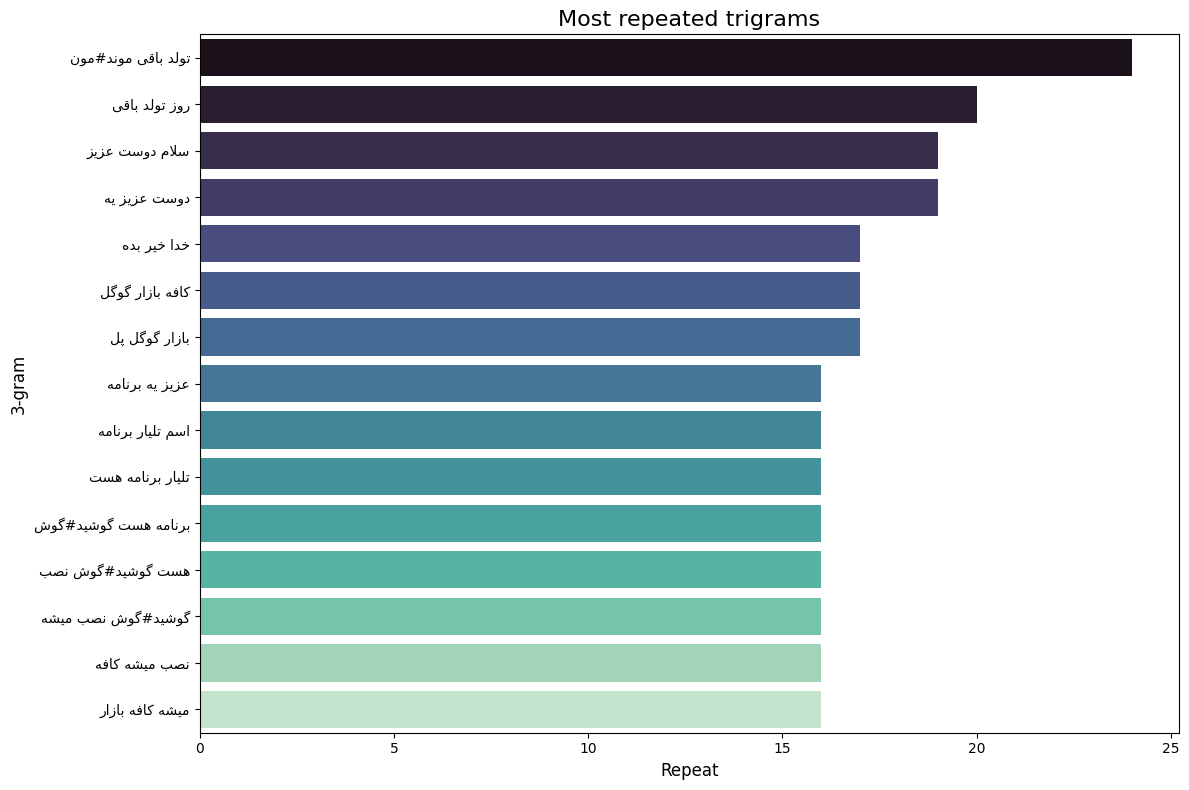

In [ ]:
def plot_top_ngrams(tokens, title, n=2, top_k=15):
    n_grams = ngrams(tokens, n)
    n_gram_counts = Counter(n_grams)

    top_ngrams = n_gram_counts.most_common(top_k)

    ngram_labels = [" ".join(gram) for gram, count in top_ngrams]
    ngram_counts = [count for gram, count in top_ngrams]

    persian_labels = [correct_persian_display(label) for label in ngram_labels]
    plt.figure(figsize=(12, 8))
    sns.barplot(x=ngram_counts, y=persian_labels, palette='mako', hue=persian_labels, legend=False)
    plt.title(correct_persian_display(title), fontsize=16)
    plt.xlabel(correct_persian_display("Repeat"), fontsize=12)
    plt.ylabel(correct_persian_display(f"{n}-gram"), fontsize=12)
    plt.tight_layout()
    plt.show()

plot_top_ngrams(answer_tokens_no_stops, "Most repeated unigrams", n=1, top_k=20)
plot_top_ngrams(answer_tokens_no_stops, "Most repeated bigrams", n=2, top_k=20)
plot_top_ngrams(answer_tokens_no_stops, "Most repeated trigrams", n=3, top_k=15)

## Analyse the dataset

In [5]:
df_2 = pd.read_json("./PerCQA_JSON_Format.json", encoding='utf-8-sig')
df_2.head()

,QID,QCATEGORY,QDATE,QUSERID,QTYPE,QGOLD_YN,QUsername,QBody,QSubject,Comments
0,1550088,NaN,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم,"[{'CID': '50758322', 'CUSERID': 4918, 'CGOLD':..."
1,1558609,NaN,2018-01-06T00:17:00,6856,General,Not Applicable,khanoomi72,من خودم حس میکنم اشتباهم گیر دادن بیخودی و غر ...,بزرگترین اشتباه دوران نامزدیتون چی بوده؟؟,"[{'CID': '51114707', 'CUSERID': 3935, 'CGOLD':..."
2,1587820,NaN,2018-01-22T13:23:00,9918,General,Not Applicable,lol,سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه....,کمک سالگرد ازدواجم نزدیکه,"[{'CID': '52336355', 'CUSERID': 10255, 'CGOLD'..."
3,4414921,NaN,2020-05-23T02:06:00,81403,General,Not Applicable,sepide1400,دختر من چهارده ماهه است. آیا برای تشخیص پرانتز...,متخصص ارتوپدی برای درمان پرانتزی پا,"[{'CID': '138006316', 'CUSERID': 38437, 'CGOLD..."
4,3109668,NaN,2019-08-13T12:07:00,25700,General,Not Applicable,نسا۷۹,چه پمادی بزنم و از چیه اینجور شده . واضح نیس...,لپ پسرم قرمز دون دونه,"[{'CID': '100859930', 'CUSERID': 33391, 'CGOLD..."


In [6]:
df_2 = df_2.dropna(subset=['QBody']).reset_index(drop=True)

In [7]:
df_2 = df_2.dropna(subset=['QID']).reset_index(drop=True)

In [8]:
df_2 = df_2.rename(columns={"QBody": "qbody", "QID": "qid"})

In [9]:
df_2.head()

,qid,QCATEGORY,QDATE,QUSERID,QTYPE,QGOLD_YN,QUsername,qbody,QSubject,Comments
0,1550088,NaN,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم,"[{'CID': '50758322', 'CUSERID': 4918, 'CGOLD':..."
1,1558609,NaN,2018-01-06T00:17:00,6856,General,Not Applicable,khanoomi72,من خودم حس میکنم اشتباهم گیر دادن بیخودی و غر ...,بزرگترین اشتباه دوران نامزدیتون چی بوده؟؟,"[{'CID': '51114707', 'CUSERID': 3935, 'CGOLD':..."
2,1587820,NaN,2018-01-22T13:23:00,9918,General,Not Applicable,lol,سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه....,کمک سالگرد ازدواجم نزدیکه,"[{'CID': '52336355', 'CUSERID': 10255, 'CGOLD'..."
3,4414921,NaN,2020-05-23T02:06:00,81403,General,Not Applicable,sepide1400,دختر من چهارده ماهه است. آیا برای تشخیص پرانتز...,متخصص ارتوپدی برای درمان پرانتزی پا,"[{'CID': '138006316', 'CUSERID': 38437, 'CGOLD..."
4,3109668,NaN,2019-08-13T12:07:00,25700,General,Not Applicable,نسا۷۹,چه پمادی بزنم و از چیه اینجور شده . واضح نیس...,لپ پسرم قرمز دون دونه,"[{'CID': '100859930', 'CUSERID': 33391, 'CGOLD..."


### Load the bge-m3 embedding model and test it.

In [10]:
model = SentenceTransformer('BAAI/bge-m3')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [11]:
random_question_text = df_2['qbody'].dropna().sample(1).iloc[0]
print(f"Original Text: {random_question_text}")

Original Text: بچم یهو میاد موهام رو میکشه. نمیدونم چیکار کنم؟  چرا اینکارو میکنه ؟


In [12]:
question_embedding = model.encode(random_question_text)

In [13]:
print(f"Type of the output: {type(question_embedding)}")
print(f"Shape of the embedding vector: {question_embedding.shape}")
print(f"First 5 elements of the vector: {question_embedding[:5]}")

Type of the output: <class 'numpy.ndarray'>
Shape of the embedding vector: (1024,)
First 5 elements of the vector: [-0.02326235  0.01962654 -0.04125646 -0.04031299 -0.03371288]


**What does it return?**

The model.encode() function returns a dense vector embedding. This is a one-dimensional array of numbers (a numpy.ndarray). For the bge-m3 model, this vector has a specific size (1024 dimensions).

**What do the components of the output represent?**

The vector itself is a high-dimensional numerical representation of the input text's meaning. Each number (or "component") in the vector represents a learned feature of the text's semantics. It's important to understand that a single component does not have a human-interpretable meaning (e.g., the 5th element doesn't represent "sports"). Instead, the entire vector as a whole captures the text's position in a "semantic space." Texts with similar meanings will have vectors that are close to each other in this space.

**Potential Uses:**

**Semantic Search**: This is the primary use for our project. By converting a user's query and all the questions in our database into these vectors, we can find the questions whose vectors are mathematically closest to the query's vector (using measures like cosine similarity). This finds results based on meaning, not just keywords.

**Clustering**: We can group similar questions together by clustering their embedding vectors.

**Classification**: The embeddings can be used as features to train a machine learning model for tasks like topic classification.

**Reranking**: As mentioned in out project description, we can use these embeddings to re-rank results from a keyword search to improve relevance.

### Install LanceDB and set up an embedding function

In [14]:
@register("bge_m3_dense")
class BGE_M3_Dense(TextEmbeddingFunction):
    _model: BGEM3FlagModel = PrivateAttr()
    def __init__(self):
        super().__init__()
        self._model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)

    def generate_embeddings(self, texts):
        embeddings_dict = self._model.encode(texts, return_dense=True)
        return embeddings_dict['dense_vecs'].tolist()

    def ndims(self):
        return 1024

registry = EmbeddingFunctionRegistry.get_instance()
bge = registry.get("bge_m3_dense").create()

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

long.jpg:   0%|          | 0.00/485k [00:00<?, ?B/s]

.DS_Store:   0%|          | 0.00/6.15k [00:00<?, ?B/s]

bm25.jpg:   0%|          | 0.00/132k [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

miracl.jpg:   0%|          | 0.00/576k [00:00<?, ?B/s]

colbert_linear.pt:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

nqa.jpg:   0%|          | 0.00/158k [00:00<?, ?B/s]

mkqa.jpg:   0%|          | 0.00/608k [00:00<?, ?B/s]

Constant_7_attr__value:   0%|          | 0.00/65.6k [00:00<?, ?B/s]

others.webp:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

long.jpg:   0%|          | 0.00/127k [00:00<?, ?B/s]

model.onnx_data:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/725k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sparse_linear.pt:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

### Define a schema for our vector database

In [15]:
class NiniSiteQuestions(LanceModel):
    qid: str
    qbody: str = bge.SourceField()
    embedding: Vector(bge.ndims()) = bge.VectorField()

In [16]:
print("--- LanceDB Schema Definition ---\n")
print(NiniSiteQuestions.schema())

--- LanceDB Schema Definition ---

{'properties': {'qid': {'title': 'Qid', 'type': 'string'}, 'qbody': {'source_column_for': {'max_retries': 7}, 'title': 'Qbody', 'type': 'string'}, 'embedding': {'items': {'type': 'number'}, 'maxItems': 1024, 'minItems': 1024, 'title': 'Embedding', 'type': 'array', 'vector_column_for': {'max_retries': 7}}}, 'required': ['qid', 'qbody', 'embedding'], 'title': 'NiniSiteQuestions', 'type': 'object'}


/tmp/ipython-input-1413586637.py:2: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  print(NiniSiteQuestions.schema())


### Create and populate a LanceDB table.

In [17]:
db = lancedb.connect("./lancedb")
questions_data = df_2[['qid', 'qbody']].drop_duplicates().reset_index(drop=True)

In [18]:
questions_data

,qid,qbody
0,1550088,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...
1,1558609,من خودم حس میکنم اشتباهم گیر دادن بیخودی و غر ...
2,1587820,سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه....
3,4414921,دختر من چهارده ماهه است. آیا برای تشخیص پرانتز...
4,3109668,چه پمادی بزنم و از چیه اینجور شده . واضح نیس...
...,...,...
985,1582862,هدایایی که برای بله برون می برن تو شهرهای مختل...
986,1790522,براي اولين بار كره ي بادوم زميني خريدم ولي نمي...
987,1574016,من ۹ماهه که عقد کردم . نامزدم ماهی۱۱۰۰حقوقشه ت...
988,4171615,بچه ها از کی به نبودن شیر عادت میکنن؟ ۳ روزه گ...


In [19]:
data_to_add = questions_data.to_dict('records')

In [20]:
table_name = "nini_questions"
if table_name in db.table_names():
    db.drop_table(table_name)
tbl = db.create_table(table_name, schema=NiniSiteQuestions)

In [21]:
tbl.add(data_to_add)
print("Data has been added and embeddings have been generated successfully!")

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 29.91it/s]
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Data has been added and embeddings have been generated successfully!


In [22]:
print(f"\nNumber of rows in the new table: {len(tbl)}")
print("\nSample of data from the table:")
print(tbl.head(5).to_pandas())


Number of rows in the new table: 990

Sample of data from the table:
       qid                                              qbody  \
0  1550088  دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...   
1  1558609  من خودم حس میکنم اشتباهم گیر دادن بیخودی و غر ...   
2  1587820  سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه....   
3  4414921  دختر من چهارده ماهه است. آیا برای تشخیص پرانتز...   
4  3109668   چه پمادی بزنم و از چیه اینجور شده  . واضح نیس...   

                                           embedding  
0  [0.04397583, 0.036621094, -0.01058197, -0.0099...  
1  [-0.037750244, -0.0014886856, -0.030914307, -0...  
2  [-0.029922485, 0.06732178, -0.038208008, 0.036...  
3  [-0.031036377, 0.018676758, -0.044403076, 0.01...  
4  [-0.01689148, 0.03353882, -0.06298828, 0.00142...  


In [23]:
# Each embedding shape
tbl.to_pandas()["embedding"][0].shape

(1024,)

### Perform semantic search

In [24]:
user_queries = [
    "آیا برای آزمایش لازم است که ناشتا باشم؟",
    "برای سالگرد ازدواجم چه هدیه ای بخرم؟",
    "کودک من چند ماهه است و پاهایش پرانتزی است، چه کنم؟",
    "شوهرم با من قهر کرده است، چگونه آشتی کنم؟",
    "علائم اولیه بارداری چیست؟"
]

for query in user_queries:
    results = tbl.search(query).limit(5).select(['qid', 'qbody']).to_pandas()
    print("="*70)
    print(f"Original Query: {query}")
    print("--- Top 5 Semantically Similar Results ---")

    if not results.empty:
        for i, row in results.iterrows():
            distance = row['_distance']
            similarity_score = 1 - distance
            print(f"  {i+1}. Result (Similarity: {similarity_score:.2f}): {row['qbody']}")
    else:
        print("  No results found for this query.")
    print("="*70 + "\n")


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Original Query: آیا برای آزمایش لازم است که ناشتا باشم؟
--- Top 5 Semantically Similar Results ---
  1. Result (Similarity: 0.25): کسی اطلاع داره ازمایش طب کار شامل چی هست می خوام بیمه بشم سر کار . بیمه فرستادتم برای ازمایش طب کار. آیا این آزمایش ناشتایی لازم داره؟ شامل چه مواردی هست؟
  2. Result (Similarity: 0.18): آزمایشی  بردین بچه هاتون و بعد از یک سالگی ؟ لازم هست؟
  3. Result (Similarity: 0.17): میشه یه ناهار سریع و خوشمزه بگید؟
  4. Result (Similarity: 0.12): کسی میدونه هزینه آزمایش قبل ازدواج الان چقد هست؟
  5. Result (Similarity: 0.10): فردا میخواهیم بریم برای نهار.  تا الان بیدار داشتم نهار میزاشتمم.  مرسی چندماه تو خونه کپک زدیم

Original Query: برای سالگرد ازدواجم چه هدیه ای بخرم؟
--- Top 5 Semantically Similar Results ---
  1. Result (Similarity: 0.83): دارم ازدواج می کنم، می خوام بدونم معمولا بهتره سالگرد ازدواج چی بهم کادو بده بهتره؟
  2. Result (Similarity: 0.47): سلااام خانوما براى ولنتاين واسه هديه چيكار مبكنيد؟ ايده بديد؟
  3. Result (Similarity: 0.46): کادوی ولتتاین

### Implement classical full-text search using LanceDB

In [25]:
tbl.create_fts_index("qbody")

In [26]:
for query in user_queries:

    search_results = tbl.search(query, query_type="fts").limit(5).to_pandas()
    print("="*70)
    print(f"Original Query: {query}")
    print("--- Top 5 Full-Text Search Results ---")

    if not search_results.empty:
        for i, row in search_results.iterrows():
            score = row['_score']
            print(f"  {i+1}. Result(Score: {score/100:.2f}): {row['qbody']}")
    else:
        print("  No results found for this query.")
    print("="*70 + "\n")

Original Query: آیا برای آزمایش لازم است که ناشتا باشم؟
--- Top 5 Full-Text Search Results ---
  1. Result(Score: 0.26): کسی اطلاع داره ازمایش طب کار شامل چی هست می خوام بیمه بشم سر کار . بیمه فرستادتم برای ازمایش طب کار. آیا این آزمایش ناشتایی لازم داره؟ شامل چه مواردی هست؟
  2. Result(Score: 0.24): پسرم سه ماهش تموم شده.  یه هفته است وارد چهار شده . هنوز غلت نمیزنه .تلاش هم نمیکنه. آیا مشکلی هست ؟ خیلی نگرانم.  در ضمن تپلی هم هست میتونه بخاطر این باشه؟. بچه های شما چندماهگی غلت زدن؟
  3. Result(Score: 0.24): دختر من چهارده ماهه است. آیا برای تشخیص پرانتزی پاهاش تا دو سالگی اش باید صبر کنم؟ متخصص ارتوپد در تهران چه کسی را پیشنهاد میکنید؟ خیلی نگران دخترم هستم. نمیخوام مثل من از پرانتزی پاش خجالت بکشه.
  4. Result(Score: 0.22): دختر من 22ماهشه اما موهای جلوی سرش هنوز رشد کافی نکرده درواقع هنوز کم مو و کم رشده، ولی پشت موهاش دم موشی شده، درصورتی که من و پدرش از لحاظ موی سرمون کلی پرمو هستیم، نگرانم من از لحاظ تغذیه کم گذاشته باشم . آیا این طبیعیه؟ 
  5. Result(Score: 0.17): من بیشتر ازی

As we can see above, for the Nini Site dataset, semantic search gives far more relevant results.

The questions are often conversational, emotional, and use varied language. Users are looking for **conceptual** matches, not just keyword hits. Semantic search's ability to understand intent and context makes it much better for this kind of informal, user-generated content. Full-text search can't really give the related questions because they are not just a couple of words and they are sentences and also because they are written with informal tone, it can have misspelled words too which results that semantic search performs better in this task.

### Research Hybrid Search Techniques

**What is Hybrid Search?**

Hybrid search is a technique that merges the results from a traditional keyword-based search (like full-text search) and a modern vector-based search (semantic search). Instead of choosing one method over the other, it runs both searches simultaneously and then intelligently combines their ranked lists to produce a single, more relevant set of results.

The core idea is to get the "best of both worlds":

The precision of keyword search.

The contextual understanding of semantic search.

**How Does It Work?**

A typical hybrid search system follows these steps:

Parallel Execution: When a user enters a query, the system sends it to two search pipelines at the same time:

The full-text search pipeline looks for exact keyword matches.

The semantic search pipeline converts the query to a vector and looks for conceptually similar items.

Scoring: Each search method returns its own ranked list of results, complete with a relevance score (_score for FTS, _distance for vector search).

Result Fusion: This is the most critical step. The two lists of results are combined using a fusion algorithm. A common and effective algorithm is Reciprocal Rank Fusion (RRF). RRF looks at the rank (position) of each document in both lists, not just its score, and recalculates a new, combined rank. This method is effective because it gives more weight to items that appear high up in both search results, signaling a strong match from both a keyword and a semantic perspective.

Final Ranking: The system presents the user with the final, reranked list of results.

**Why is Hybrid Search More Effective?**

Hybrid search is often more effective than using a single method alone because the two approaches have complementary strengths and weaknesses. One method's weakness is the other's strength.

In [27]:
for query in user_queries:
    search_results = tbl.search(query, query_type="hybrid").limit(5).to_pandas()
    print("="*70)
    print(f"Original Query: {query}")
    print("--- Top 5 Full-Text Search Results ---")

    if not search_results.empty:
        for i, row in search_results.iterrows():
            print(f"  {i+1}. : {row['qbody']}")
    else:
        print("  No results found for this query.")
    print("="*70 + "\n")

Original Query: آیا برای آزمایش لازم است که ناشتا باشم؟
--- Top 5 Full-Text Search Results ---
  1. : کسی اطلاع داره ازمایش طب کار شامل چی هست می خوام بیمه بشم سر کار . بیمه فرستادتم برای ازمایش طب کار. آیا این آزمایش ناشتایی لازم داره؟ شامل چه مواردی هست؟
  2. : آزمایشی  بردین بچه هاتون و بعد از یک سالگی ؟ لازم هست؟
  3. : پسرم سه ماهش تموم شده.  یه هفته است وارد چهار شده . هنوز غلت نمیزنه .تلاش هم نمیکنه. آیا مشکلی هست ؟ خیلی نگرانم.  در ضمن تپلی هم هست میتونه بخاطر این باشه؟. بچه های شما چندماهگی غلت زدن؟
  4. : میشه یه ناهار سریع و خوشمزه بگید؟
  5. : دختر من چهارده ماهه است. آیا برای تشخیص پرانتزی پاهاش تا دو سالگی اش باید صبر کنم؟ متخصص ارتوپد در تهران چه کسی را پیشنهاد میکنید؟ خیلی نگران دخترم هستم. نمیخوام مثل من از پرانتزی پاش خجالت بکشه.

Original Query: برای سالگرد ازدواجم چه هدیه ای بخرم؟
--- Top 5 Full-Text Search Results ---
  1. : سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه. عقدم هستیم . کادو براش تا الان عطر و زنجیر و گردنبند طلا و ست چرم برای تولدو مناسبتهای قبل خرید

### Evaluation methods

While manual checking gives an intuitive feel for search quality, standardized metrics are essential for objectively measuring and comparing the performance of different search systems. Here are the most common metrics used in information retrieval.


#### 1. Precision@k (Precision at k)

**Precision@k** answers the question: "Of the top 'k' results the system showed me, how many were actually relevant?" It's a measure of immediate quality at the very top of the search results.

* **How it works:** You count the number of relevant documents within the top *k* positions and divide by *k*.
* **Formula:**
    ```
    Precision@k = (Number of relevant results in the top k) / k
    ```
* **Example:** If you look at the top 5 results (k=5) and 4 of them are relevant, the Precision@5 is `4 / 5 = 0.8`.
* **Use Case:** Ideal for web search or e-commerce, where user satisfaction depends heavily on the first few results they see.


#### 2. Recall

**Recall** answers the question: "Of all the relevant documents that exist in the entire database, what fraction did my search system find?" It measures the "completeness" or "thoroughness" of the search.

* **How it works:** You count the number of relevant documents your system retrieved and divide it by the *total* number of relevant documents that exist in the whole dataset.
* **Formula:**
    ```
    Recall = (Number of relevant results retrieved) / (Total number of relevant documents in the dataset)
    ```
* **Example:** If there are 20 documents about "pregnancy" in the entire dataset and your search returns 15 of them, your recall is `15 / 20 = 0.75`.
* **Use Case:** Crucial in situations where it's important to not miss any relevant documents, such as in legal discovery or medical research.


#### 3. NDCG (Normalized Discounted Cumulative Gain)

**NDCG** is a more sophisticated metric that is considered the industry standard for evaluating ranked lists. It is powerful because it rewards putting more relevant documents higher up in the results.

* **How it works:**
    1.  **Cumulative Gain (CG):** It starts by summing up the relevance scores of the results. Unlike Precision, relevance can be graded (e.g., a "perfect" result gets a score of 3, a "good" one 2, etc.).
    2.  **Discounted Cumulative Gain (DCG):** It then "discounts" the scores of results that appear lower down the list. A perfect result at position 1 is worth more than a perfect result at position 10.
    3.  **Normalized DCG (NDCG):** Finally, it normalizes this score by dividing it by the score of a *perfectly* ordered list. This gives a final score between 0.0 and 1.0, where 1.0 is a perfect ranking.
* **Use Case:** It is the preferred metric in most modern search systems, especially when the quality of the ranking order itself is the most important factor.

### Answer Ranking Enhancement with a Reranker (Bonus)

In [30]:
reranker_model = CrossEncoder('BAAI/bge-reranker-base')

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [36]:
for query in user_queries:
    initial_results = tbl.search(query, query_type="vector").limit(10).to_pandas()
    rerank_pairs = []
    for i, row in initial_results.iterrows():
        rerank_pairs.append([query, row['qbody']])

    if rerank_pairs:
        rerank_scores = reranker_model.predict(rerank_pairs)
        initial_results['rerank_score'] = rerank_scores
        reranked_results = initial_results.sort_values(by='rerank_score', ascending=False)
    else:
        reranked_results = pd.DataFrame()

    print("="*80)
    print(f"Original Query: {query}")
    print("\n--- Initial Semantic Search Results ---")
    if not initial_results.empty:
        for i, row in initial_results.iterrows():
            print(f"  {i+1}. (Score: {1-row['_distance']:.2f}): {row['qbody']}")

    print("\n--- Final Reranked Results ---")
    if not reranked_results.empty:
        j = 1
        for _, row in reranked_results.iterrows():
            print(f"  {j}. (Score: {row['rerank_score']:.2f}): {row['qbody']}")
            j += 1
    else:
        print("  No results found.")
    print("="*80 + "\n")



Original Query: آیا برای آزمایش لازم است که ناشتا باشم؟

--- Initial Semantic Search Results ---
  1. (Score: 0.25): کسی اطلاع داره ازمایش طب کار شامل چی هست می خوام بیمه بشم سر کار . بیمه فرستادتم برای ازمایش طب کار. آیا این آزمایش ناشتایی لازم داره؟ شامل چه مواردی هست؟
  2. (Score: 0.18): آزمایشی  بردین بچه هاتون و بعد از یک سالگی ؟ لازم هست؟
  3. (Score: 0.17): میشه یه ناهار سریع و خوشمزه بگید؟
  4. (Score: 0.12): کسی میدونه هزینه آزمایش قبل ازدواج الان چقد هست؟
  5. (Score: 0.10): فردا میخواهیم بریم برای نهار.  تا الان بیدار داشتم نهار میزاشتمم.  مرسی چندماه تو خونه کپک زدیم
  6. (Score: 0.10): برای آزمایش ازدواج باید نامه از محضر گرفت یا برعکس برای محضر باید نامه آزمایشکاه برد؟ کلا روالش چجوریه ؟من دو سال از عقدم میگذره کلا فراموش کردم . حالا واسه دوستم که ازم پرسیده از شما کمک میخوام . کی یادشه؟
  7. (Score: 0.10): دیروز موعدم بود نشدم تا الان .بنظرتو بی بی چک بزنم یا صبر کنم؟ 
  8. (Score: 0.09): کسی هست امسال ارشد زبان بخواد آزمون بده؟؟
  9. (Score: 0.09): دوستان بیاین راهنمایی

#### Comparison and Analysis of Results
The reranker significantly improves the quality of the results by catching subtle mismatches that the initial semantic search might miss.

For the query برای سالگرد ازدواجم چه هدیه ای بخرم؟ :

Initial Search Might Return: A question about a "birthday gift" high up in the list because "birthday" and "anniversary" are semantically close concepts.

Reranked Results Will: Push the "birthday gift" question down. The cross-encoder, by analyzing both the query and document together, will notice the specific word "anniversary" is a better match than "birthday" and give it a higher score. It understands the nuance.

For the query شوهرم با من قهر کرده است، چگونه آشتی کنم؟ :

Initial Search Might Return: A document that talks about a fight with a "friend" or "brother" because the concept of a dispute is similar.

Reranked Results Will: Prioritize documents that specifically mention "شوهر" or "نامزد" . The cross-encoder's deeper analysis will identify that the relationship context is a crucial part of the query and will reward documents that match it perfectly.
